# AirBnB Recruiting Challenge (Kaggle)

**Ruben Bloom**

- email: <rmb042@gmail.com>
- github: [darkruby501](https://github.com/darkruby501)

**Can we predict where a new AirBnB user will make their first booking?**

> New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.
In this recruiting competition, Airbnb challenges you to predict in which country a new user will make his or her first booking. - [AirBnB Recruiting New User Bookings Challenge on Kaggle](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings)


Skewed Multiclass challenge.

## Summary

**Contents**

1. Problem Definition and the Data (Introduction)
    * Problem Definition
    * Files
    * The Measure - NDCG
    * A Note About Data Quality
3. Data Preparation: Wrangling, Cleaning, and Feature Extraction
4. Machine Learning Models
    1. Logistic Regression
        * Parameter Optimisation
    2. Random Forest
        * Confusion Matrices
        * Classification Report
        * Feature Importances
        * Validation Curve
        * Learning Curve
    3. Further Attempts
        * Imbalance / Sampling Techniques
        * One-vs-One
        * "Staged Classifiers"
5. Results and Findings
    * Untried Ideas
6. Technical Conclusion
7. Practical Recommendations
    * Evaluating recommendations

In [2]:
Image(filename='airbnb_homepage_suggestions.png',width=600)

NameError: name 'Image' is not defined

# Acknowledgements

I give thanks and credit to my Springboard mentor, Karthik Ramasay, who advised me throughout this project. And to the Kaggle community whose forum provided much useful advice, especically David Gasquez whose initial Data Exploration was especially helpful. While the project as a whole is mine, various pieces were learnt from the examples of others.

# Start your kernels!

In [3]:
from IPython.core.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("talk", font_scale=1.1)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 1. Introduction

## Problem Definition
All users are from the US


**Skewed Multiclass Classificaiton Problem:**

12 classes. Below show that there is signficant skews

### Measure: Normalised Cumulative Discounted Gain

$$DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}$$

Normalised DCG is calculated by dividing the actual DCG by the maximum possible (ideal) DCG. In our case where relevance is binrary and only one result is "relevant", the maximum possible DCG is one, and so the NDCG reduces to DCG formula.


- https://www.kaggle.com/wiki/NormalizedDiscountedCumulativeGain
- https://www.kaggle.com/wendykan/airbnb-recruiting-new-user-bookings/ndcg-example
- https://gist.github.com/bwhite/3726239

In [4]:
# Create a NDCG scorer function for use with Scikit-Learn.
from rank_metrics import ndcg_at_k
from sklearn.metrics import make_scorer

def ndcg_wrapper(y_true,y_pred_proba):
    Y = np.fliplr(y_pred_proba.argsort())
      
    R = []
    NDCG = []
    for i in range(0,y_true.size):
        r = (Y[i,:]==y_true[i]).astype(int)
        R.append(r)
        NDCG.append(ndcg_at_k(r,5,method=1))
    return np.mean(NDCG)

ndcg_scorer = make_scorer(ndcg_wrapper, greater_is_better=True, needs_proba=True)

for i in range(0,5):
    print("Correct Destination in Position %d: NDGG = %.3f" % (i,ndcg_at_k([0]*i+[1],5,1)))

Correct Destination in Position 0: NDGG = 1.000
Correct Destination in Position 1: NDGG = 0.631
Correct Destination in Position 2: NDGG = 0.500
Correct Destination in Position 3: NDGG = 0.431
Correct Destination in Position 4: NDGG = 0.387


## Files Provided 
**train_users_2.csv, test_users.csv**

This is the primary database and includes user age, gender, language, time first active, date account created, sign up method, sign up flow, affiliate information, first device, first browser, and ultimate country destination of first booking.

**sessions.csv**

The sessions file contains browsing information for users at the level of individual actions. Action, action type, action detail, device type (e.g. Windows/Mac/Android/Mobile) and seconds elapsed since previous action are included. Examples rows in Table 1.

**age_gender_bkt.csv**

This file contains the number of users in each age and gender bracket, e.g. (Female, 24-29), travelling to each destination in 2015.

**countries.csv**

This file contains information on each country destination, including latitude and longitude of the country, distance from the US, size of the country, language in the country, and the Levenshtein distance  from English to the country’s language.

## A Note About Data Quality
It should be noted that the quality of the data is unlikely to perfect. As with most user data collected online, the recording is imperfect. 

Consider that AirBnB attempts to log when a user was first active, as well as track their sessions. This is difficult because of the Many Screens Problem . A user may have been browsing extensively on one computer, perhaps at work, and then make the actual booking at home. It will appear that the user booked spontaneously without browsing. Similarly, many people browse on mobile but book at full computer. Until a user has created an account and is signed in, this is difficult to track.

Ultimately, we cannot be sure that any recorded data about a user is the complete picture of their behavioural pattern. We should expect that the data is noisy.


http://www.kaushik.net/avinash/multi-channel-attribution-definitions-models/


# 2. Data Preparation: Wrangling, Cleaning, and Feature Extraction

### Main Files: train_users.csv, test_users.csv
These are the main files for the competition and include basic information about users, including the label of which country they booked in. First let's take a little look.

In [5]:
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')
piv_train = train_users.shape[0] # Store length of train_users file
labels = train_users['country_destination'].values

all_users = pd.concat([train_users,test_users],axis=0,ignore_index=True) #Combine train and test for joint processing.

In [6]:
all_users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


Note how date_first_booking has a few NaN values, that's because people who didn't book don't have first booking dates! We will discard this column, but initially this data leak caused the restart of the AirBnB competition.

In [7]:
## Get rid of date_first_booking
if 'date_first_booking' in all_users.columns:
    all_users.drop(['date_first_booking'],axis=1,inplace=True)

In [8]:
all_users.columns

Index(['affiliate_channel', 'affiliate_provider', 'age', 'country_destination',
       'date_account_created', 'first_affiliate_tracked', 'first_browser',
       'first_device_type', 'gender', 'id', 'language', 'signup_app',
       'signup_flow', 'signup_method', 'timestamp_first_active'],
      dtype='object')

The train and test user files contain the above fields.

In [9]:
print("Number of Users in the Training Set = ",train_users.shape[0])
print("Number of Users in the Test Set = ",test_users.shape[0])
print('\n')
print('Earliest "Date Account Created" in Training Set:',pd.to_datetime(train_users['date_account_created']).min())
print('Latest "Date Account Created" in Training Set:',pd.to_datetime(train_users['date_account_created']).max())
print('Earliest "Date Account Created" in Test Set:',pd.to_datetime(test_users['date_account_created']).min())
print('Latest "Date Account Created" in Training Set:',pd.to_datetime(test_users['date_account_created']).max())

Number of Users in the Training Set =  213451
Number of Users in the Test Set =  62096


Earliest "Date Account Created" in Training Set: 2010-01-01 00:00:00
Latest "Date Account Created" in Training Set: 2014-06-30 00:00:00
Earliest "Date Account Created" in Test Set: 2014-07-01 00:00:00
Latest "Date Account Created" in Training Set: 2014-09-30 00:00:00


Training Set contains users from the period January 2010 - June 2014. Test Set contains users from July - September 2014.

In [10]:
np.unique(train_users['country_destination'])

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

Destination Countries: Australia, Canada, Germany, Spain, France, Great Britain, Italy, "No Destination Found", Netherlands, Portugal, USA, "other".

No Destination Found means no booking was made for that user within the measured period. "Other" means a booking was made to a country not already listed.

### Imbalanced Classes
Very imbalanced. The bulk do not book.

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


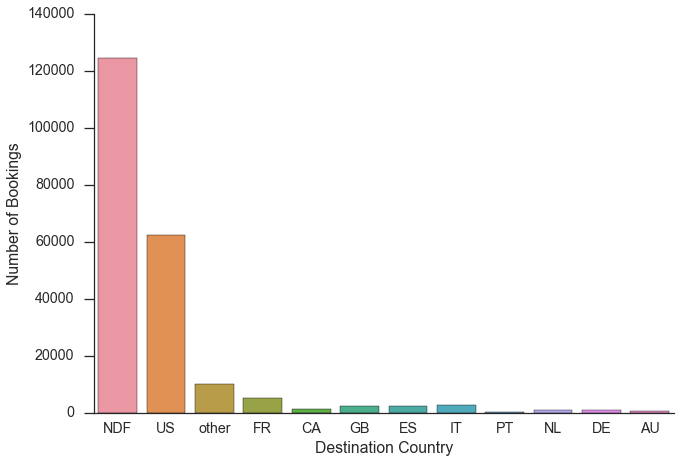

In [11]:
sns.countplot(x="country_destination",data=train_users)
plt.xlabel('Destination Country')
plt.ylabel('Number of Bookings')
sns.despine()

#### Missing Values
Let's take a look for missing values. First the dataframe above showed that missing gender values were filled with "-unknown-". Need to fix that.

In [12]:
all_users['gender'].replace('-unknown-',np.nan, inplace=True)

How much data is missing?

In [13]:
all_nan = (all_users.isnull().sum() / all_users.shape[0]) * 100
all_nan[all_nan > 0]

age                        42.412365
country_destination        22.535538
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

42% of ages values are missing and 47% of gender values are missing. The date_first_booking can be disregared as noted above. *first_affiliate_tracked* is missing only a few percent of valeus, but inspection shows that 50% of the first_affiliate_tracked values are "untracked", so we might as well fill those NaNs with "untracked".

In [14]:
# How many first_affiliate_tracked values are "untracked"?
print(sum(all_users['first_affiliate_tracked']=='untracked')/len(all_users))
all_users['first_affiliate_tracked'].fillna('untracked',inplace=True)


0.519624601248


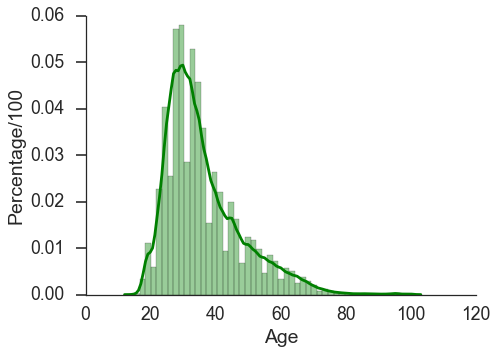

In [28]:
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

fig = plt.figure(figsize=(7,5))
sns.distplot(all_users.loc[all_users['age']>0,'age'], color='green',kde=True,norm_hist=True)
sns.despine()
plt.xlabel('Age')
plt.ylabel('Percentage/100')

#### Age
Age is missing a lot of values, so it needs a closer look. Examination shows that the minimum age is 1 (much too young!) and the oldest age is 2014 (quite a record!). There are 2749 invalid entries which I will lump together with the missing values by setting them to NaN.

In [15]:
all_users['age'].describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [16]:
print(sum(all_users.age > 100))
print(sum(all_users.age < 15))

2690
59


In [17]:
all_users.loc[all_users['age'] > 100, 'age'] = np.nan
all_users.loc[all_users['age'] < 15, 'age'] = np.nan

### Missing at random? Or not?
Although it is common to blithely replace missing values with mean, median or randomly, we cannot do so before asking about the nature of the missing values. How did they come to be missing?

In our case, age and gender values are missing because users didn't fill them in, or didn't fill them in correctly. As we might expect users with more serious intentions to fill out forms correctly, it is important information to know whether a user did or did not. Crucially there may be difference in behaviour between the cluster of female 20-24 year olds who did fill out the forms and those who didn't. We don't want to prematurely collapse that distinction. 

For this reason, I chose to set missing ages to -1 so that the trained classifier might treat them as their own category. As a Logistic Regression classifier cannot handle non-linear features in this manner, I later impute the median before training it.

See *Data Analysis Using Regression and Multilevel/Heirarchical Models, [Ch. 25](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)*, by Gelman and Hill for a great intro to handling missing values.

In [18]:
all_users['age'].fillna(-1,inplace=True) #replace missing values with out of range value.

#### One-Hot Encoding of Categorical Features
To the make data suitable for a classifier, categorical variables (including gender) were converted to one-hot encoding. E.g. the gender feature become three mutually exclusive, binary features: gender_FEMALE, gender_MALE, and gender_OTHER. If a user entered 'female', gender_FEMALE will correspondingly be high.

The creation of dummy values provides a solution to the missing gender values. Instead of needing to impute missing values, after one-hot encoding, users with no gender entered will have 0 in all gender features. It was also possible to create a gender_NaN column, althouh I have not tested if this improves accuracy. 

In [ ]:
## One-Hot Encoding
categorical_features = ['affiliate_channel','affiliate_provider','first_affiliate_tracked',
                      'first_browser','first_device_type','gender','language','signup_app','signup_flow','signup_method']
all_users = pd.get_dummies(all_users,columns=categorical_features)

#### Discretisation of Age
To further aid the machine learning models with non-linear data, the age feature was also transformed into discrete age brackets, e.g [20-24], similar to the one-hot encoding. The original numerical age feature was retained.

In [ ]:
# Discretise Age
A = pd.cut(all_users['age'],list(range(14,100,5)),right=True)
A = pd.get_dummies(A)
all_users = pd.concat([all_users,A],axis=1)

#### Splitting of Dates
To allow the classifiers to more easily pick up patterns in the data at different time scales, date and time values were split into YEAR/MONTH/DAY/HOUR rather than a single numerical value. 

In [ ]:
# Split date components

# date_account_created
dac = np.vstack(all_users.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
all_users['dac_year'] = dac[:,0]
all_users['dac_month'] = dac[:,1]
all_users['dac_day'] = dac[:,2]
all_users.drop(['date_account_created'],axis=1,inplace=True)

#time first active
tfa = np.vstack(all_users.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
all_users['tfa_year'] = tfa[:,0]
all_users['tfa_month'] = tfa[:,1]
all_users['tfa_day'] = tfa[:,2]
all_users['tfa_hour'] = tfa[:,3]
all_users.drop(['timestamp_first_active'],axis=1,inplace=True)

### Session Files: sessions.csv

List of actions for each user.

Users only for 2014 onwards. All test users. 


In [5]:
session_df = pd.read_csv('input/sessions.csv')
session_users = session_df
session_df.head(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683


Need process this into features! Count up different actions types for each user (Combining Action-Action Detail since action_type seems relatively boring.

There are some missing values, but these are not a problem. Some website actions just don't take any time, so we can set them as zero. Some actions don't have a "type".

In [6]:
# Clean missing values
session_users['secs_elapsed'].fillna(0,inplace=True)
session_users['action_type'].fillna('',inplace=True)

#### Action Counts

In [7]:
# Create New Combined Feature for Grouping
session_users['action_action_detail'] = session_users['action']+'__'+session_users['action_detail']
session_users2 = session_users.groupby(['user_id','action_action_detail']).count()['secs_elapsed'].unstack().fillna(0)

Let's take quick peak at the features just created. And the number of them created.

In [10]:
print(session_users2.shape)
session_users2.head(2)

(135038, 436)


action_action_detail,10__message_post,11__message_post,12__message_post,15__message_post,about_us__-unknown-,accept_decline__host_respond_page,account__-unknown-,acculynk_bin_check_failed__-unknown-,acculynk_bin_check_success__-unknown-,acculynk_load_pin_pad__-unknown-,...,verify__-unknown-,view__p3,views__-unknown-,views_campaign__-unknown-,views_campaign_rules__-unknown-,webcam_upload__-unknown-,weibo_signup_referral_finish__-unknown-,why_host__-unknown-,wishlists__-unknown-,zendesk_login_jwt__-unknown-
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0010k6l0om,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Time Spent on Each Device Type
something, something, something

In [14]:
deviceusage_df = session_df[session_df['secs_elapsed']<60*100][['user_id','device_type','secs_elapsed']].groupby(['user_id','device_type']).sum().unstack()['secs_elapsed']

device_type,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch
user_id,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,25452,0,0,0,0,0,5089,0
0010k6l0om,0,0,0,0,0,0,36884,0,0,0,0,0,0,0


Separately, we can extract the number of different device types usesd by a user to access AirBnB.

In [16]:
deviceusage_df['num_devices'] = session_df.groupby('user_id')['device_type'].agg(lambda x: len(np.unique(x.values)))
deviceusage_df.fillna(0,inplace=True)
deviceusage_df.head(2)

#### Features Related to Session Length
Examining the session records, it's clear that the "secs_elapsed" (since previous action) variable is extremely large for actions. I assume that these large values mark the periods between different occasions that a user was continuious engaging with the AirBnB website, e.g. spent 20 minutes browsing Tuesday morning, and then another 40 minute on Thursday evening. 

With appropriate processing, a number of new features can be extracted from the session logs, including: number of sessions, length spent website, maximum and average times between sessions, average seconds per action, and few others.

In [21]:
## Features about individual sessions (sittings)
in_session_actions = session_df[session_df['secs_elapsed']<60*100].groupby('user_id')
AA = in_session_actions['secs_elapsed'].agg({'total_session_times': np.sum,
                                        'mean_secs_per_action' : np.mean,
                                            'num_actions_insession' : np.size})

## Features related to the number of sessions 
between_session_actions = session_df[session_df['secs_elapsed']>200*60].groupby('user_id')
BB = between_session_actions['secs_elapsed'].agg({'num_sessions': np.size,
                                            'mean_between_sessions' : np.mean,
                                            'max_between_sessions': np.max
                                            })

session_times = pd.merge(AA,BB,how='outer',left_index=True,right_index=True)

#Count number of different days spent on AirBnB. Obtained by looking for number of breaks longer than 18 hours.
session_times['num_days'] = session_df[session_df['secs_elapsed']>18*3600].groupby('user_id').count()['secs_elapsed']
session_times.fillna(0,inplace=True)
session_times['num_sessions'] += 1 # Doesn't really make a difference
session_times['days'] += 1 

In [23]:
session_times.head(3)

,total_session_times,mean_secs_per_action,num_actions_insession,max_between_sessions,mean_between_sessions,num_sessions,num_days
user_id,,,,,,,
00023iyk9l,30541,954.406250,32,567165,118202.428571,8,2
0010k6l0om,36884,768.416667,48,127898,46397.636364,12,3
001wyh0pz8,96785,1240.833333,78,50548,22506.333333,7,0


In [25]:
## Join all session features together
SessionFeatures = pd.merge(session_users2,deviceusage_df,right_index=True,left_index=True,how='inner')
SessionFeatures = pd.merge(SessionFeatures,session_times,right_index=True,left_index=True,how='inner')
SessionFeatures.head(2)

,10__message_post,11__message_post,12__message_post,15__message_post,about_us__-unknown-,accept_decline__host_respond_page,account__-unknown-,acculynk_bin_check_failed__-unknown-,acculynk_bin_check_success__-unknown-,acculynk_load_pin_pad__-unknown-,...,iPhone,iPodtouch,num_devices,total_session_times,mean_secs_per_action,num_actions_insession,max_between_sessions,mean_between_sessions,num_sessions,num_days
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,0,0,0,0,...,5089,0,2,30541,954.406250,32,567165,118202.428571,8,2
0010k6l0om,0,0,0,0,0,0,0,0,0,0,...,0,0,1,36884,768.416667,48,127898,46397.636364,12,3


#### Session Feature Selection
Generated A LOT of features. Slow down training. Feature selection using SelectKBest. F-ANOVA to each variable. Sample sizes vary significantly, so the ANOVA might be a little messy ... but whatever.

In [38]:
## Need to attach labels for feature selection.
SessionX = pd.merge(train_users[['id','country_destination']],SessionFeatures,right_index=True,left_on='id',how='inner')
Sessiony = SessionX['country_destination']!="NDF" # Turn this into a binary classification problem
SessionX.drop(['id','country_destination'],axis=1,inplace=True)

In [30]:
# Perform selection
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=150)
selector.fit(SessionX,Sessiony)
#SessionFeatures = SessionFeatures[SessionFeatures.columns[selector.get_support()]]

c:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  5   7  10  12  15  16  63  65  80  82  83  84  85  89  90  92 114 124
 127 131 135 136 141 154 171 179 188 196 197 198 199 200 201 203 239 258
 259 319 324 332 334 335 339 343 348 349 360 362 378 383 386 390 393 411
 427] are constant.
  UserWarning)


SelectKBest(k=150, score_func=<function f_classif at 0x000000001A1FF048>)

The warning reveals a number of features which really ought to go.

In [31]:
FeaturePvalues = pd.Series(index=SessionX.columns,data=selector.pvalues_).sort_values(ascending=True)
FeatureScores = pd.Series(index=SessionX.columns,data=selector.scores_).sort_values(ascending=False)

In [44]:
FeaturePvalues.head5

AttributeError: 'Series' object has no attribute 'head5'

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


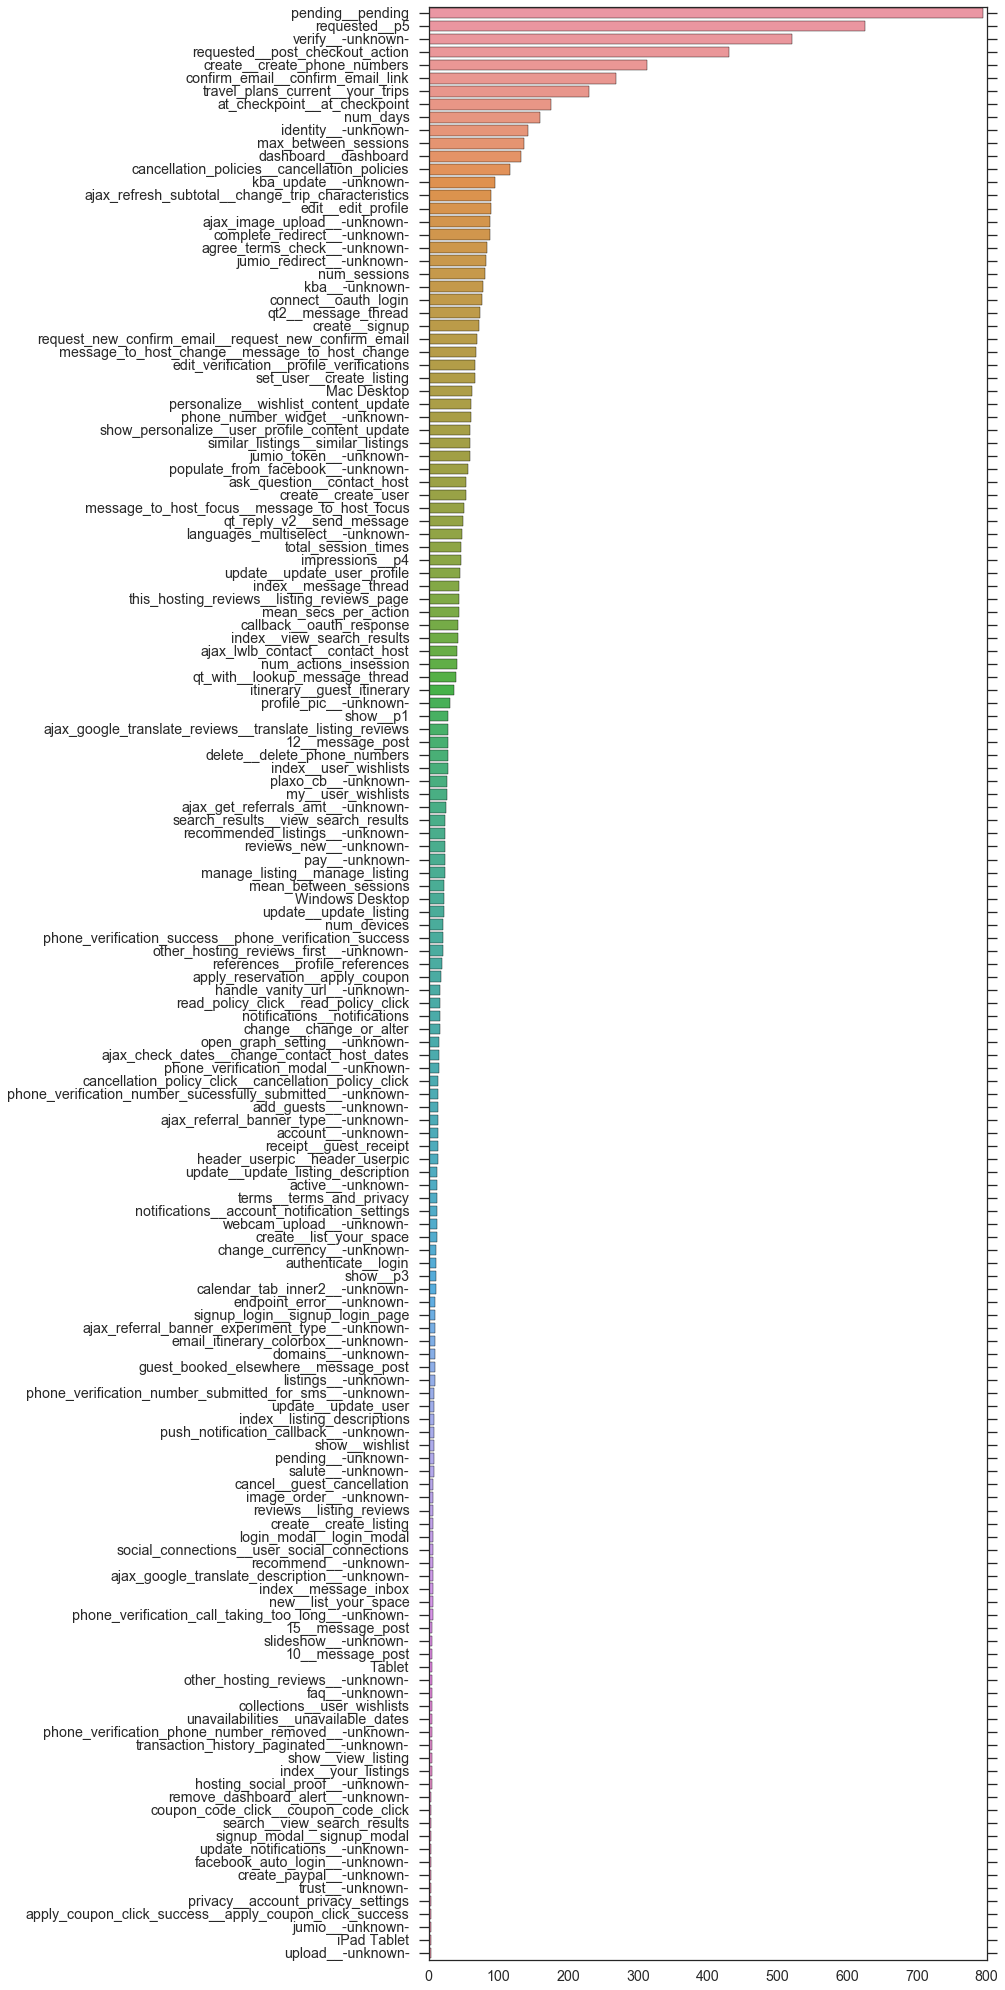

In [42]:
k = 150
plt.figure(figsize=(10,35))
sns.barplot(y=FeatureScores.index[0:k],x=FeatureScores.head(k))
#plt.xticks(rotation = 90)

### age_gender_brackets.csv

In [ ]:
age_gender_df = pd.read_csv('input/age_gender_bkts.csv')
age_gender_df.head()

Learing curve below, more data won't help!

In [ ]:
#Not Missing at Random! 


#See Chapter 25 of Data Analysis Using Regression and Multilevel/Hierarchical Models
# (www.stat.columbia.edu/~gelman/arm/missing.pdf)

Using only data from 2014 loses some seasonal information.